Grid approach

In [55]:
import numpy as np
import matplotlib.pyplot as pl
from scipy import stats
import seaborn as sb
% matplotlib inline

In [24]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)
    print(prior)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

Assuming we made 4 tosses and we observe only 1 head we have the following

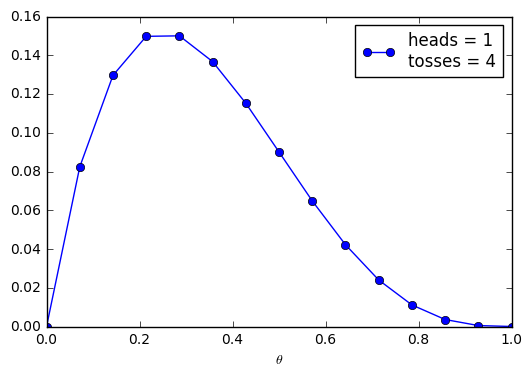

In [9]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
pl.plot(grid, posterior, 'o-', label='heads = {}\ntosses = {}'.format(h, n))
pl.xlabel(r'$\theta$')
pl.legend(loc=0)

In [26]:
# create some data
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data=stats.bernoulli.rvs(p=theta_real,size=n_experiments)
print(data)

[1 0 0 0]


In [25]:
import pymc3 as pm

In [28]:
with pm.Model() as first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 3.819085
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 1000/1000 [00:01<00:00, 871.82it/s]


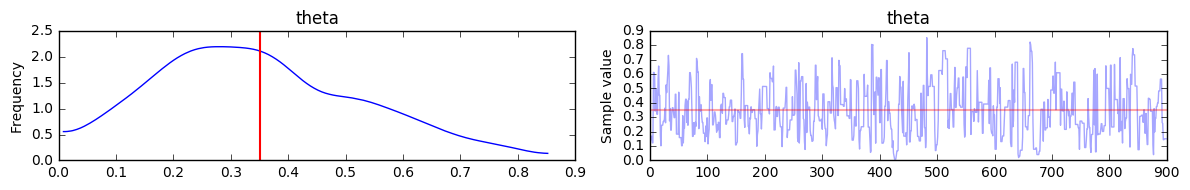

In [41]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});

100%|██████████| 1000/1000 [00:00<00:00, 3776.94it/s]


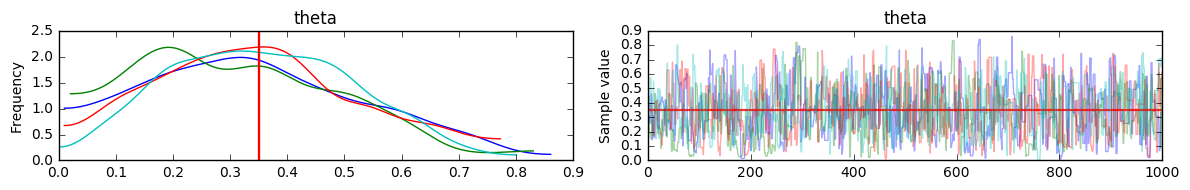

In [30]:
with first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, njobs=4)
burnin = 0
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_chain, lines={'theta':theta_real});

In [31]:
# gelman_rubin test (aka R-hat): OK if <1.1
pm.gelman_rubin(multi_chain)

{'theta': 1.0047487480287749, 'theta_logodds_': 1.0052428426394659}

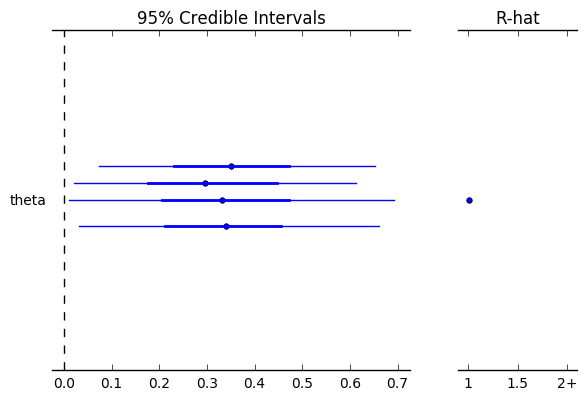

In [32]:
pm.forestplot(multi_chain, varnames=['theta'])

In [34]:
pm.df_summary(multi_chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta,0.34201,0.175763,0.006068,0.030194,0.664321


What is mc_error?
This is an estimation of the error introduced by the sampling method.
It takes into account that the samples are not truly independent of each other: $$ MC_{error} = \frac{\sigma\left(x\right)}{\sqrt n}$$

** This error should be below the precision we want in our results**.

### AUTOCORRELATION

It should dissipate rapidly.  The more autocorrelated a parameter is, the larger the number of samples we will need to obtain a given precision; that is, autocorrelation has the detrimental effect of lowering the effective number of samples.

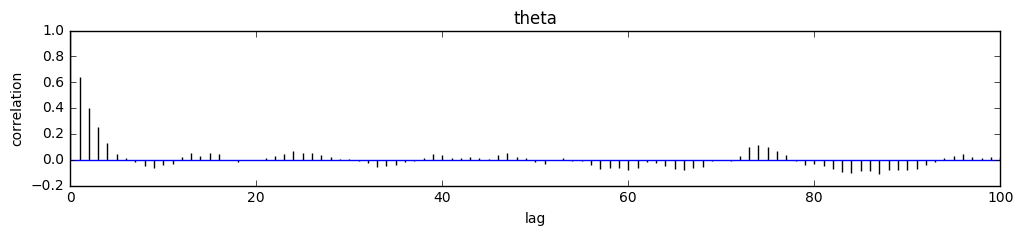

In [40]:
pm.autocorrplot(chain);

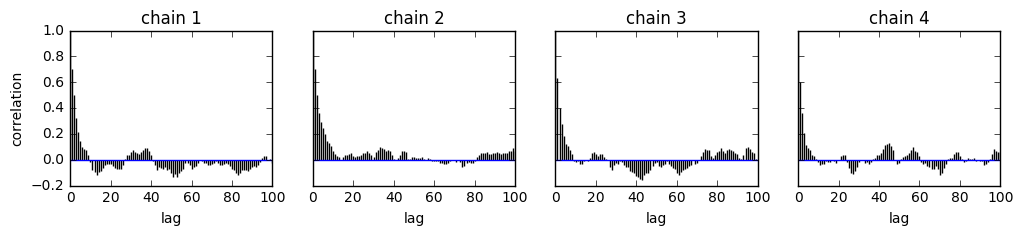

In [37]:
pm.autocorrplot(multi_chain);

### Effective Size

A sample with autocorrelation has less information than a sample of the same size without autocorrelation. Hence, given a sample of a certain size with a certain degree of autocorrelation we could try to estimate what will be the size of the sample with the same information without autocorrelation. That number will be the effective size of the sample. 

In [43]:
pm.effective_n(multi_chain)['theta']

758.0

One way to have more efficient sampling is of course to use a better sampling method. An alternative is to transform the data or re-parametrize the model. Another commonly used option in the literature is to thin a chain.

### Summarizing the posterior

The result of a Bayesian analysis is a posterior distribution. This contains all the information about our parameters, according to the data and the model. One way to visually summarize the posterior is to use the plot_posterior function that comes with PyMC3. This function accepts a PyMC3 trace or a NumPy array as a main argument. By default, plot_posterior shows a histogram for the credible parameters together with the mean of the distribution and the 95% HPD as a thick black line at the bottom of the plot. Different interval values can be set for the HPD with the argument alpha_level. We are going to refer to this type of plot as Kruschke's plot.

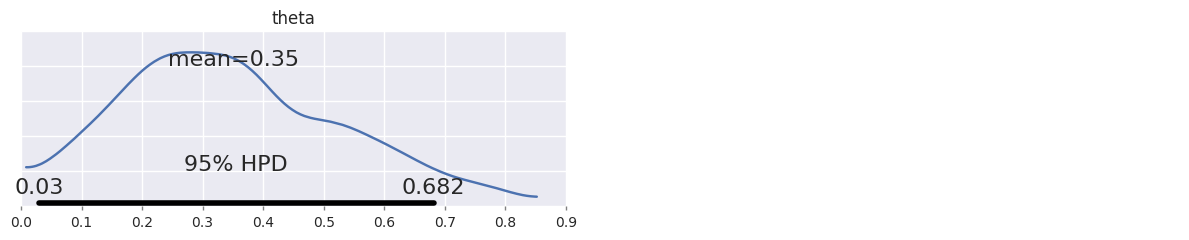

In [70]:
pm.plot_posterior(chain, kde_plot=True);

### Posterior-based decisions

Sometimes describing the posterior is not enough. Sometimes we need to make decisions based on our inferences. We have to reduce a continuous estimation to a dichotomous one: yes or no, contaminated or safe, and so on.

Intuitively, one way to take such an informed decision is to compare the HPD to the value of interest, 0.5 in our case. In the preceding figure, we can see that the HPD goes from ~ 0.06 to ~0.71 and hence 0.5 is included in the HPD. According to our posterior, the coin seems to be tail-biased, but we cannot completely rule out the possibility that the coin is fair; maybe if we want a sharper decision we will need to collect more data to reduce the spread of the posterior or maybe we missed some important information that we could use to define a more informative prior.

### ROPE

One possible option to take a posterior-based decision is to define a **Region Of Practical Equivalence (ROPE)**. This is just an interval around the value of interest; for example, we could say that any value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. Once again the ROPE is context-dependent. So, now we are going to compare the ROPE to the HPD. We can define at least three scenarios:

* The ROPE does not overlap with the HPD, and hence we can say the coin is not fair
* The ROPE contains the entire HPD; we will say the coin is fair
* The ROPE partially overlaps with HPD; we cannot say the coin is fair or unfair 

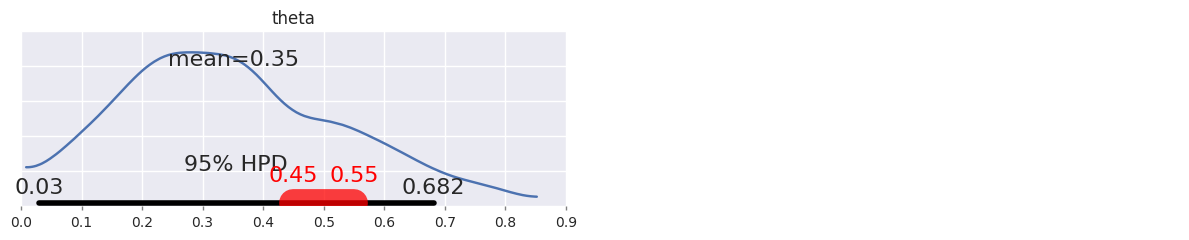

In [72]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, 0.55]);

We can also pass to plot_posterior a reference value, for example 0.5, that we want to compare with the posterior. We will get a green vertical line and the proportion of the posterior above and below our reference value

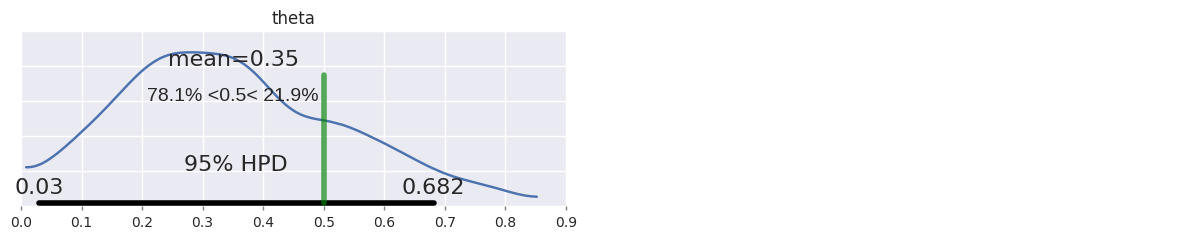

In [74]:
pm.plot_posterior(chain, kde_plot=True, ref_val=0.5);

For a more detailed discussion of the use of the ROPE you could read chapter 12 of the great book Doing Bayesian Data Analysis by John Kruschke.

### Loss functions

If you think these ROPE rules sound a little bit clunky and you want something more formal, loss functions are what you are looking for! To make a good decision it is important to have the highest possible level of precision for the estimated value of some parameter, but it is also important to take into account the cost of making a mistake. The benefit/cost trade-off can be mathematically formalized using cost functions, also know as loss functions. A loss function tries to capture the cost of predicting X (the coin is fair) when Y (the coin is not fair) turns out to be true. In many problems, the cost of making a decision is asymmetric. It is not the same to decide that it is safe not to administer a certain vaccine to children under five and being right, that being wrong. Making a bad decision could cost thousands of lives and produce a health crisis that could be avoided by administrator a relatively cheap and very safe vaccine. The subject of making good informed decisions has been studied for years and is known as **decision theory**.